# Batch Normalization

Il est courant de normaliser la couche d'entrée dans le but d'accélérer l'apprentissage, ainsi que d'améliorer les performances en redimensionnant toutes les fonctionnalités à la même échelle. Donc, la question est, si le modèle bénéficie de la normalisation de la couche d'entrée, pourquoi ne pas normaliser la sortie de toutes les couches cachées pour tenter d'améliorer encore plus la vitesse d'entraînement ?

La normalisation par lots, comme son nom l'indique, normalise les sorties des couches cachées afin de réduire la variance de chaque couche, également appelée décalage de covariance. Cette réduction du décalage de covariance est utile car elle permet au modèle de bien fonctionner également sur des images qui suivent une distribution différente de celle des images utilisées pour l'entraîner.

Prenons, par exemple, un réseau qui a pour but de détecter si un animal est un chat. Lorsque le réseau est entraîné uniquement à l'aide d'images de chats noirs, la normalisation par lots peut aider le réseau à classer également de nouvelles images de chats de couleurs différentes en normalisant les données de sorte que les images de chat noir et coloré suivent une distribution similaire.

De plus, la normalisation par lots présente les avantages suivants au processus de formation du modèle, ce qui vous aide finalement à arriver à un modèle plus performant:

* Il permet de définir un taux d'apprentissage plus élevé, car la normalisation par lots permet de s'assurer qu'aucune des sorties n'est trop élevée ou trop faible. Un taux d'apprentissage plus élevé équivaut à des temps d'apprentissage plus rapides

* Il permet de réduire le surdébit car il a un effet de régularisation. Cela permet de définir la probabilité d'abandon sur une valeur inférieure, ce qui signifie que moins d'informations sont ignorées à chaque passage en avant.

Comme nous l'avons expliqué dans les sections précédentes, la normalisation de la sortie d'une couche cachée se fait en soustrayant la moyenne du lot et en divisant par l'écart type du lot.

De plus, la normalisation par lots est généralement effectuée sur les couches convolutives, ainsi que les couches FC (à l'exclusion de la couche de sortie)

## Batch Normalization with PyTorch

Dans PyTorch, l'ajout de la normalisation par lots est aussi simple que l'ajout d'une nouvelle couche à l'architecture du réseau, étant donné qu'il existe deux types différents, comme expliqué ici

 * **BatchNorm1d** : cette couche est utilisée pour implémenter la normalisation par lots sur une entrée bidimensionnelle ou tridimensionnelle. Il reçoit le nombre de nœuds de sortie de la couche précédente comme argument. Ceci est couramment utilisé sur les couches FC

* **BatchNorm2d** : Ceci applique la normalisation par lots aux entrées en quatre dimensions. Encore une fois, l'argument qu'il prend est le nombre de nœuds de sortie de la couche précédente. Il est couramment utilisé sur les couches convolutives, ce qui signifie que l'argument qu'il prend doit être égal au nombre de canaux de la couche précédente

Selon cela, la mise en œuvre de la normalisation par lots dans un CNN est la suivante :

In [ ]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.norm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.norm2 = nn.BatchNorm2d(20)
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1)
        self.norm3 = nn.BatchNorm2d(40)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.linear1 = nn.Linear(40 * 4 * 4, 100)
        self.norm4 = nn.BatchNorm1d(100)
        self.linear2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.norm1(F.relu(self.conv1(x))))
        x = self.pool(self.norm2(F.relu(self.conv2(x))))
        x = self.pool(self.norm3(F.relu(self.conv3(x))))

        x = x.view(-1, 40 * 4 * 4)
        x = self.dropout(x)
        x = self.norm4(F.relu(self.linear1(x)))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        
        return x

Comme nous pouvons le voir, les couches de normalisation par lots sont initialement définies de manière similaire à toute autre couche à l'intérieur de la méthode __init__. Ensuite, chaque couche de normalisation par lots est appliquée à la sortie de sa couche correspondante après la fonction d'activation à l'intérieur de la méthode forward

## Implementing Batch Normalization

In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
transform = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(0.5), 
        transforms.RandomGrayscale(0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [3]:

batch_size = 100

train_data = datasets.CIFAR10('data3', train=True, download=True, transform=transform["train"])
test_data = datasets.CIFAR10('data3', train=False, download=True, transform=transform["test"])

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data3/cifar-10-python.tar.gz to data3
Files already downloaded and verified


In [4]:
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(dev_size * len(train_data)))
train_idx, dev_idx = idx[split_size:], idx[:split_size]

train_sampler = SubsetRandomSampler(train_idx)
dev_sampler = SubsetRandomSampler(dev_idx)

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=dev_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.norm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.norm2 = nn.BatchNorm2d(20)
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1)
        self.norm3 = nn.BatchNorm2d(40)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.linear1 = nn.Linear(40 * 4 * 4, 100)
        self.norm4 = nn.BatchNorm1d(100)
        self.linear2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.norm1(F.relu(self.conv1(x))))
        x = self.pool(self.norm2(F.relu(self.conv2(x))))
        x = self.pool(self.norm3(F.relu(self.conv3(x))))

        x = x.view(-1, 40 * 4 * 4)
        x = self.dropout(x)
        x = self.norm4(F.relu(self.linear1(x)))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        
        return x

In [7]:
model = CNN().to("cuda")
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [8]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs+1):
    losses = 0
    acc = 0
    iterations = 0
    
    model.train()
    for data, target in train_loader:
        iterations += 1

        pred = model(data.to("cuda"))
        loss = loss_function(pred, target.to("cuda"))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        p = torch.exp(pred)
        top_p, top_class = p.topk(1, dim=1)
        acc += accuracy_score(target.to("cpu"), top_class.to("cpu"))
        
    dev_losss = 0
    dev_accs = 0
    iter_2 = 0
        
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        
        with torch.no_grad():
            model.eval()
            
            for data_dev, target_dev in dev_loader:
                iter_2 += 1
                
                dev_pred = model(data_dev.to("cuda"))
                dev_loss = loss_function(dev_pred, target_dev.to("cuda"))
                dev_losss += dev_loss.item()

                dev_p = torch.exp(dev_pred)
                top_p, dev_top_class = dev_p.topk(1, dim=1)
                dev_accs += accuracy_score(target_dev.to("cpu"), dev_top_class.to("cpu"))
        
        train_losses.append(losses/iterations)
        dev_losses.append(dev_losss/iter_2)
        train_acc.append(acc/iterations)
        dev_acc.append(dev_accs/iter_2)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(losses/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_losss/iter_2),
              "Training Accuracy: {:.3f}.. ".format(acc/iterations),
              "Validation Accuracy: {:.3f}".format(dev_accs/iter_2))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1/100..  Training Loss: 1.432..  Validation Loss: 1.157..  Training Accuracy: 0.491..  Validation Accuracy: 0.592
Epoch: 5/100..  Training Loss: 0.914..  Validation Loss: 0.850..  Training Accuracy: 0.679..  Validation Accuracy: 0.707
Epoch: 10/100..  Training Loss: 0.792..  Validation Loss: 0.763..  Training Accuracy: 0.721..  Validation Accuracy: 0.730
Epoch: 15/100..  Training Loss: 0.724..  Validation Loss: 0.722..  Training Accuracy: 0.745..  Validation Accuracy: 0.748
Epoch: 20/100..  Training Loss: 0.683..  Validation Loss: 0.695..  Training Accuracy: 0.760..  Validation Accuracy: 0.760
Epoch: 25/100..  Training Loss: 0.662..  Validation Loss: 0.687..  Training Accuracy: 0.766..  Validation Accuracy: 0.761
Epoch: 30/100..  Training Loss: 0.639..  Validation Loss: 0.670..  Training Accuracy: 0.775..  Validation Accuracy: 0.767
Epoch: 35/100..  Training Loss: 0.621..  Validation Loss: 0.679..  Training Accuracy: 0.778..  Validation Accuracy: 0.762
Epoch: 40/100..  Training 

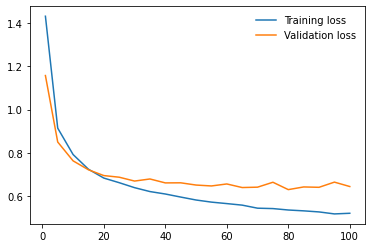

In [9]:
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

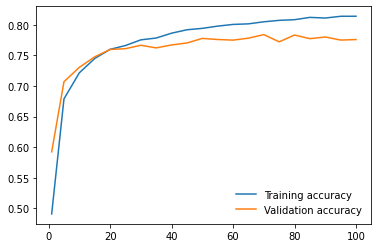

In [10]:
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [11]:
model.eval()
iter_3 = 0
acc_test = 0
for data_test, target_test in test_loader:
    iter_3 += 1
    test_pred = model(data_test.to("cuda"))
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    acc_test += accuracy_score(target_test.to("cpu"), top_class_test.to("cpu"))
print(acc_test/iter_3)

0.7812000000000003
